# Notes:

- This implementation is a replicate of coordconv uniform dataset classification task from the paper "An intriguing failing of convolutional neural networks and the CoordConv solution" by R.Liu et al. (2018) from Uber AI. 

- The model takes coordinates as an input

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf

In [2]:
#retrieve data from folder

#references: https://github.com/titu1994/keras-coordconv/blob/master/experiments/train_uniform_classifier.py
train_onehot = np.load('coordconv_data/train_onehot.npy').astype('float32')
test_onehot = np.load('coordconv_data/test_onehot.npy').astype('float32')

#retrieve coordinates
coord_train = np.where(train_onehot == 1.0)
coord_test = np.where(test_onehot == 1.0)

#Training coords 
x_coord_train = coord_train[1]
y_coord_train = coord_train[2]

#Test coords
x_coord_test = coord_test[1]
y_coord_test = coord_test[2]

In [3]:
train_set = np.zeros((len(x_coord_train), 1, 1, 2), dtype='float32')
test_set = np.zeros((len(x_coord_test), 1, 1, 2), dtype='float32')

for i ,(x, y) in enumerate(zip(x_coord_train, y_coord_train)):
    train_set[i, 0, 0, 0] = x #1st channel x coord 
    train_set[i, 0, 0, 1] = y #2nd channel y coord

for i ,(x, y) in enumerate(zip(x_coord_test, y_coord_test)):
    test_set[i, 0, 0, 0] = x #1st channel x coord 
    test_set[i, 0, 0, 1] = y #2nd channel y coord    
    
train_set = np.tile(train_set, [1, 64, 64, 1])
#train_set.shape[0] (64, 64, 2) => return: 1st channel, 64 numbers of same x_coord ..
test_set = np.tile(test_set, [1, 64, 64, 1])

In [4]:
#normalizing dataset

train_set /= (64. - 1.) 
test_set /= (64. - 1.) 
print('Train set : shape: {}, max value:{}, min value: {}'. format(train_set.shape, train_set.max(), train_set.min()))
print('Test set : : shape: {}, max value:{}, min value: {} '.format(test_set.shape, test_set.max(), test_set.min()))

Train set : shape: (2508, 64, 64, 2), max value:0.9365079402923584, min value: 0.0634920671582222
Test set : : shape: (628, 64, 64, 2), max value:0.9365079402923584, min value: 0.0634920671582222 


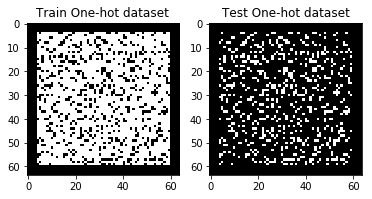

In [5]:
# Plot dataset
fig, (ax1, ax2) = plt.subplots(1, 2) 
ax1.imshow(np.sum(train_onehot, axis=0)[:, :, 0], cmap='gray')
ax1.set_title('Train One-hot dataset')

ax2.imshow(np.sum(test_onehot, axis=0)[:, :, 0], cmap='gray')
ax2.set_title('Test One-hot dataset')
plt.show()

Training data set label #0, x coordinate: 


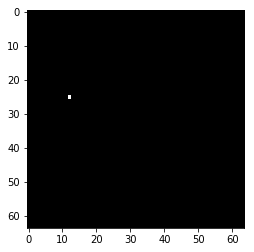

In [6]:
for i in range(len(train_onehot)):
    plt.imshow(train_onehot[i, :, :, 0], cmap='gray')
    print("Training data set label #{}, x coordinate: ".format(i))
    plt.show()
    break
#     if input()== 'exit':
#         break

In [7]:
#flatten one hot labels for final layer
train_onehot = train_onehot.reshape((-1, 64 * 64)) #shape(batch, 64*64)
test_onehot = test_onehot.reshape((-1, 64 * 64))

In [8]:
#model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Softmax
from coord_conv import CoordConv

class coordconv(Model):
    def __init__(self):
        super(coordconv, self).__init__()
        
        self.pre_mode = Sequential([
                tf.keras.layers.InputLayer(input_shape=(64, 64, 2)),
                CoordConv(x_dim = 64, y_dim = 64, with_r = False, filters = 64, 
                      kernel_size = 1, padding='same', activation='relu'),
                Conv2D(filters = 32, kernel_size = 1, strides = 1,
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 32, kernel_size = 1, strides = 1,
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 64, kernel_size = 1, strides = 1, 
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 64, kernel_size = 1, strides = 1, 
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 1, kernel_size = 1, strides = 1, 
                       padding = "same" ),
                Flatten(),
                ])
        
        self.post_mode = Sequential([
                tf.keras.layers.InputLayer(input_shape=(64, 64, 2)),
                CoordConv(x_dim = 64, y_dim = 64, with_r = False, filters = 64, 
                      kernel_size = 1, padding='same', activation='relu'),
                Conv2D(filters = 32, kernel_size = 1, strides = 1,
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 32, kernel_size = 1, strides = 1,
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 64, kernel_size = 1, strides = 1, 
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 64, kernel_size = 1, strides = 1, 
                       padding = "same", activation = 'relu'), 
                Conv2D(filters = 1, kernel_size = 1, strides = 1, 
                       padding = "same" ),
                Flatten(),
                Softmax(),
                ])
        
    def pre_soft(self, inp):
        return self.pre_mode(inp)
    
    def post_soft(self, inp):
        return self.post_mode(inp)
    

In [9]:
# Alternative implementation with lower level API 

BATCH_SIZE = 32
MAX_STEP = 5000
lr = 1e-3

model = coordconv()

ds_train = tf.data.Dataset.from_tensor_slices((train_set, train_onehot)).shuffle(10000).repeat(100).batch(BATCH_SIZE)

opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.CategoricalAccuracy()


@tf.function
def train_fn(imgs, lbls):
    with tf.GradientTape() as tape:
        output = model.post_soft(imgs)
        loss = loss_fn(lbls, output)
        #pre-softmax output
        pre_soft = model.pre_soft(imgs)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(lbls, output)
    return output, pre_soft

pre_soft_list = []
onehot_image_list = []
output_list = []

for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps > MAX_STEP:
        print('End of steps!')
        break

    output, pre_soft = train_fn(img_batch, lbl_batch)
    pre_soft_list.append(pre_soft[0]) # 1st image 
                                      # of each batch shape(64*64)
    onehot_image_list.append(lbl_batch[0])
    output_list.append(output[0])
    Template = 'Step: {}, Loss: {}, Accuracy: {}'

    if not steps % 100:
        print(Template.format(steps, train_loss.result(), train_acc.result()))

W0708 00:07:33.512448 140427230598912 optimizer_v2.py:928] Gradients does not exist for variables ['coord_conv/conv2d/kernel:0', 'coord_conv/conv2d/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'conv2d_4/kernel:0', 'conv2d_4/bias:0', 'conv2d_5/kernel:0', 'conv2d_5/bias:0'] when minimizing the loss.
W0708 00:07:34.112294 140427230598912 optimizer_v2.py:928] Gradients does not exist for variables ['coord_conv/conv2d/kernel:0', 'coord_conv/conv2d/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'conv2d_4/kernel:0', 'conv2d_4/bias:0', 'conv2d_5/kernel:0', 'conv2d_5/bias:0'] when minimizing the loss.


Step: 0, Loss: 8.31312084197998, Accuracy: 0.0
Step: 100, Loss: 6.615070819854736, Accuracy: 0.049504950642585754
Step: 200, Loss: 4.1240434646606445, Accuracy: 0.41417911648750305
Step: 300, Loss: 2.7993335723876953, Accuracy: 0.6067276000976562
Step: 400, Loss: 2.1064252853393555, Accuracy: 0.7048004865646362
Step: 500, Loss: 1.6878851652145386, Accuracy: 0.7637225389480591
Step: 600, Loss: 1.407929539680481, Accuracy: 0.803036630153656
Step: 700, Loss: 1.2075637578964233, Accuracy: 0.8311340808868408
Step: 800, Loss: 1.0571179389953613, Accuracy: 0.8522160053253174
Step: 900, Loss: 0.9399974942207336, Accuracy: 0.8686181902885437
Step: 1000, Loss: 0.8462737798690796, Accuracy: 0.8817432522773743
Step: 1100, Loss: 0.7695527076721191, Accuracy: 0.8924841284751892
Step: 1200, Loss: 0.7055498957633972, Accuracy: 0.9014363288879395
Step: 1300, Loss: 0.6513774991035461, Accuracy: 0.9090123176574707
Step: 1400, Loss: 0.604927659034729, Accuracy: 0.9155067801475525
Step: 1500, Loss: 0.56466

In [10]:
pre_soft_list = np.asarray(pre_soft_list[0])

pre_soft_list = pre_soft_list.reshape((-1, 64, 64, 1))

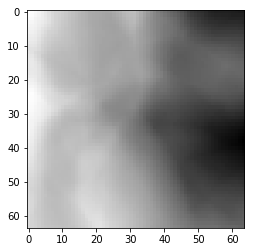

In [11]:
plt.imshow(np.reshape(pre_soft_list[0],(64, 64)), cmap = 'gray')
plt.show()

In [12]:
#pre_soft_list[0].dtype
tmp_01 = np.where(pre_soft_list[0]==np.max(pre_soft_list[0]))

In [13]:
tmp_01

(array([25]), array([0]), array([0]))

In [20]:
np.max(pre_soft_list[0])

0.04196794

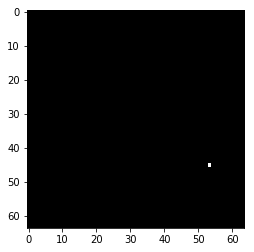

In [14]:
plt.imshow(np.reshape(onehot_image_list[0],(64, 64)), cmap = 'gray')
plt.show()

In [15]:
z = onehot_image_list[0].numpy()
z = z.reshape((-1, 64, 64, 1))
tmp_02 = np.where(z==np.max(z))

In [16]:
tmp_02

(array([0]), array([45]), array([53]), array([0]))

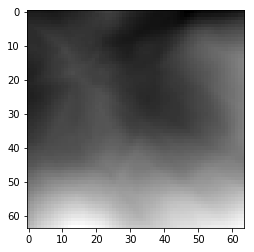

In [17]:
output_list = np.asarray(output_list[0])
output_list = output_list.reshape((-1, 64, 64, 1))
plt.imshow(np.reshape(output_list[0],(64, 64)), cmap = 'gray')
plt.show()